In [1]:
import os 
import jinja2
import pandas as pd
from jinja2 import Template
import py3Dmol
import cclib
import rdkit
from rdkit import Chem

In [2]:
with open('job_TEMPLATE.txt') as file_:
    template = Template(file_.read())
    
gens_ = ["gens_434", "gens_50", "gens_502", "gens_547", "gens_75", "gens_547"]

gen_dirs = [x for x in gens_ if x.startswith("gens_") and len(os.listdir(x)) > 0]

for d in gen_dirs:
    for f in os.listdir(d):
        #print(d, f)
        filepath = os.path.join(d,f)
        atoms = open(filepath).readlines()[2:]
        atoms_str = ""
        for line in atoms:
            atoms_str += line
        output = template.render(chk=f"{d}_{f}.chk", atoms=atoms_str)
        
        with open(f"jobs2/{d}_{f}.com", "w") as f:
            f.write(output)
        
        
#print(output)

In [3]:
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addModel(open("gens_50/gen2.xyz").read(), "xyz")
xyzview.setStyle({'stick':{}})
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
folder = "jobs"
output = [f"{folder}/{x}" for x in os.listdir(folder) if x.endswith("out") and x.startswith("gens")]
output_text = [open(x).readlines() for x in output]
termination = [x[-1].startswith(" Normal") if len(x) > 0 else False for x in output_text]

type_ = ["GEN"]*len(termination)

folder2 = "jobs2"
output2 = [f"{folder2}/{x}" for x in os.listdir(folder2) if x.endswith("out") and x.startswith("gens")]
output_text2 = [open(x).readlines() for x in output2]
termination2 = [x[-1].startswith(" Normal") if len(x) > 0 else False for x in output_text2]

type_2 = ["GEN"]*len(termination2)

folder3 = "train"
output3 = [f"{folder3}/{x}" for x in os.listdir(folder3) if x.endswith("out")]
output_text3 = [open(x).readlines() for x in output3]
termination3 = [x[-1].startswith(" Normal") if len(x) > 0 else False for x in output_text3]

type_3 = ["TRAIN"]*len(termination3)

folder4 = "test"
output4 = [f"{folder4}/{x}" for x in os.listdir(folder4) if x.endswith("out")]
output_text4 = [open(x).readlines() for x in output4]
termination4 = [x[-1].startswith(" Normal") if len(x) > 0 else False for x in output_text4]

type_4 = ["TEST"]*len(termination4)

type_.extend(type_2)
output.extend(output2)
termination.extend(termination2)

type_.extend(type_3)
output.extend(output3)
termination.extend(termination3)

type_.extend(type_4)
output.extend(output4)
termination.extend(termination4)

df = pd.DataFrame({"output": output, "success": termination, "type": type_})

In [5]:
success1 = df[df["success"]]
success1

,output,success,type
0,jobs/gens_1191_gen17.xyz.out,True,GEN
1,jobs/gens_98-86_gen13.xyz.out,True,GEN
2,jobs/gens_98-86_gen4.xyz.out,True,GEN
3,jobs/gens_62_gen1.xyz.out,True,GEN
4,jobs/gens_1191_gen3.xyz.out,True,GEN
...,...,...,...
255,test/50-0-0.out,True,TEST
256,test/502-49-8.out,True,TEST
257,test/547-64-8.out,True,TEST
258,test/75-89-8.out,True,TEST


In [6]:
# job = "gens_502_gen5.xyz.out"
# filename = f"{folder}/{job}"
import numpy as np

def conditions(freq, disp):
    if 3400 < freq < 3780:
        if sum(sum(disp[-3:])) != 0:# and sum(sum(disp[:-3])) != 0:
            return True
            
def analyse_opt(filename):
    output = {"filename": [], "freq": [], "disp": [], "atomnos": [], "atomcoords": []}
    data = cclib.io.ccread(filename)
    
    for i, freq in enumerate(data.vibfreqs):
        disp = data.vibdisps[i]
        if conditions(freq, disp):
            output["filename"].append(filename)
            output["freq"].append(freq)
            output["disp"].append(disp)
            output["atomnos"].append(data.atomnos)
            output["atomcoords"].append(data.atomcoords)
            
    if len(output["filename"]) > 0:
        return output
    else:
        return None
      
    
data_dictionaries = []

for job in list(success1["output"]):
    result = analyse_opt(job)
    if result is not None:
        data_dictionaries.append(result)
    



In [7]:
df_dict = {}

for d in data_dictionaries:
    df_dict.update(d)
    
df = pd.DataFrame(data_dictionaries)
df["disp"]

0      [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1      [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
2      [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
3      [[[-0.05, 0.01, 0.0], [0.0, 0.0, 0.0], [0.0, 0...
4      [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
                             ...                        
174    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [-0.01, -0...
175    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
176    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [-0.01, 0....
177    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
178    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: disp, Length: 179, dtype: object

In [8]:
df

,filename,freq,disp,atomnos,atomcoords
0,[jobs/gens_1191_gen17.xyz.out],[3651.2351],"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[8, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 8, 1, 1]]","[[[[ 2.254732 -1.111407 0.139695], [ 1.076708..."
1,[jobs/gens_98-86_gen13.xyz.out],[3606.1652],"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,...","[[[[-1.598772 2.354839 0.002411], [-1.726478..."
2,[jobs/gens_98-86_gen4.xyz.out],[3601.7481],"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,...","[[[[ 1.500511 -1.865639 0.014759], [ 0.956523..."
3,"[jobs/gens_62_gen1.xyz.out, jobs/gens_62_gen1....","[3487.8021, 3544.3211, 3691.5085]","[[[-0.05, 0.01, 0.0], [0.0, 0.0, 0.0], [0.0, 0...","[[7, 6, 6, 6, 6, 6, 6, 7, 6, 8, 1, 1, 1, 1, 1,...","[[[[-1.305979 -1.956823 -0.215492], [-0.176785..."
4,[jobs/gens_1191_gen3.xyz.out],[3601.4333],"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[6, 6, 8, 6, 6, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1,...","[[[[ 3.555492 -1.135439 0.812448], [ 2.480557..."
...,...,...,...,...,...
174,[test/50-0-0.out],[3692.3172],"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [-0.01, -0...","[[6, 8, 1, 1, 8, 1, 1]]","[[[[1.229976e+00 4.554520e-01 5.420000e-04], [..."
175,[test/502-49-8.out],[3578.1188],"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[[[-2.366504 -0.721183 -0.566332], [-2.352693..."
176,"[test/547-64-8.out, test/547-64-8.out]","[3555.8714, 3610.2268]","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [-0.01, 0....","[[6, 6, 1, 6, 1, 1, 1, 6, 1, 1, 1, 8, 8, 8, 1,...","[[[[0.368967 1.247959 0.554036], [-0.590295 0..."
177,[test/75-89-8.out],[3607.1661],"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[6, 6, 1, 1, 8, 1, 9, 9, 9, 8, 1, 1]]","[[[[-0.254547 1.066764 -0.624224], [-0.861207..."


In [9]:
import matplotlib.pyplot as plt
import scipy 
from sklearn.decomposition import PCA

atomnos = []
for i in list(df["atomnos"]):
    for j in i:
        atomnos.append(j)
        
atomcoords = []
for i in list(df["atomcoords"]):
    for j in i:
        atomcoords.append(j)    
        
filenames = []
for i in list(df["filename"]):
    for j in i:
        filenames.append(j)

freqs = []
for i in list(df["freq"]):
    for j in i:
        freqs.append(j)
        
disps = []
for i in list(df["disp"]):
    for j in i:
        disps.append(j)
        
        
processed_df = pd.DataFrame({"filename": filenames, "atomno": atomnos, "atomcoords": atomcoords, "freq": freqs, "disp": disps}) 
# scipy.linalg.svd(disps[0])
        
# plt.hist(freqs)
processed_df

,filename,atomno,atomcoords,freq,disp
0,jobs/gens_1191_gen17.xyz.out,"[8, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 8, 1, 1]","[[[2.254732, -1.111407, 0.139695], [1.076708, ...",3651.2351,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
1,jobs/gens_98-86_gen13.xyz.out,"[6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...","[[[-1.598772, 2.354839, 0.002411], [-1.726478,...",3606.1652,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
2,jobs/gens_98-86_gen4.xyz.out,"[6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...","[[[1.500511, -1.865639, 0.014759], [0.956523, ...",3601.7481,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
3,jobs/gens_62_gen1.xyz.out,"[7, 6, 6, 6, 6, 6, 6, 7, 6, 8, 1, 1, 1, 1, 1, ...","[[[-1.305979, -1.956823, -0.215492], [-0.17678...",3487.8021,"[[-0.05, 0.01, 0.0], [0.0, 0.0, 0.0], [0.0, 0...."
4,jobs/gens_62_gen1.xyz.out,"[7, 6, 6, 6, 6, 6, 6, 7, 6, 8, 1, 1, 1, 1, 1, ...","[[[-1.305979, -1.956823, -0.215492], [-0.17678...",3544.3211,"[[0.03, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...,...,...,...
244,test/502-49-8.out,"[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[-2.366504, -0.721183, -0.566332], [-2.35269...",3578.1188,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
245,test/547-64-8.out,"[6, 6, 1, 6, 1, 1, 1, 6, 1, 1, 1, 8, 8, 8, 1, ...","[[[0.368967, 1.247959, 0.554036], [-0.590295, ...",3555.8714,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [-0.01, 0.0..."
246,test/547-64-8.out,"[6, 6, 1, 6, 1, 1, 1, 6, 1, 1, 1, 8, 8, 8, 1, ...","[[[0.368967, 1.247959, 0.554036], [-0.590295, ...",3610.2268,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [-0.01, 0.0..."
247,test/75-89-8.out,"[6, 6, 1, 1, 8, 1, 9, 9, 9, 8, 1, 1]","[[[-0.254547, 1.066764, -0.624224], [-0.861207...",3607.1661,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."


In [48]:
atomcoords[1].shape

(33, 21, 3)

In [10]:
water_disps = [x[-3:].flatten() for x in disps]
non_zero = [np.count_nonzero(x[:-3].flatten())/3 for x in disps]

pca = PCA(n_components=1)
pca_result = pca.fit_transform(water_disps)
pca.explained_variance_ratio_
# pca.singular_values_
# water_disps

array([0.31968477])

Text(0, 0.5, 'Freq.')

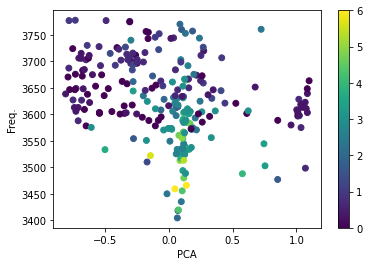

In [11]:
cm = plt.cm.get_cmap('viridis')
sp = plt.scatter(pca_result, freqs, c=non_zero, vmin=0, vmax=max(non_zero), s=35, cmap=cm)
plt.colorbar(sp)
plt.xlabel("PCA")
plt.ylabel("Freq.")
# plt.show()
# plt.scatter(non_zero, freqs)
# plt.show()
# plt.scatter(non_zero, pca_result)


In [15]:
smiles_file = open("jobs/smiles").readlines()
smiles_dict = { "jobs/"+x.split()[1]: x.split()[0] for x in smiles_file}
rdkit_dict = {f"jobs/{x.split()[1]}": Chem.MolFromSmiles(x.split()[0]) for x in smiles_file}

smiles_file2 = open("jobs2/smiles").readlines()
smiles_dict2 = {f"jobs2/{x.split()[1]}": x.split()[0] for x in smiles_file2}
rdkit_dict2 = {f"jobs2/{x.split()[1]}": Chem.MolFromSmiles(x.split()[0]) for x in smiles_file2}

smiles_file3 = open("train/smiles").readlines()
smiles_dict3 = {f"train/{x.split()[1]}": x.split()[0] for x in smiles_file3}
rdkit_dict3 = {f"train/{x.split()[1]}": Chem.MolFromSmiles(x.split()[0]) for x in smiles_file3}

smiles_file4 = open("test/smiles").readlines()
smiles_dict4 = {f"test/{x.split()[1]}": x.split()[0] for x in smiles_file4}
rdkit_dict4 = {f"test/{x.split()[1]}": Chem.MolFromSmiles(x.split()[0]) for x in smiles_file4}

rdkit_dict.update(rdkit_dict2)
rdkit_dict.update(rdkit_dict3)
rdkit_dict.update(rdkit_dict4)

processed_df["mol"] = processed_df["filename"].apply(lambda x: rdkit_dict[x])
processed_df["svg"] = processed_df["mol"].apply(lambda x: mol2svg(x))
processed_df["type"] = processed_df["filename"].apply(lambda x: x.split("/")[0] if not x.__contains__("jobs2") else x.split("/")[0][:-1])

RDKit WARNING: [14:24:09] WARNING: not removing hydrogen atom without neighbors


In [16]:
processed_df["pca"] = pca_result
processed_df["contacts"] = non_zero
processed_df[-20:]

,filename,atomno,atomcoords,freq,disp,mol,svg,type,pca,contacts
229,train/288-32-4.out,"[6, 6, 6, 1, 1, 1, 7, 1, 7, 8, 1, 1]","[[[0.966984, 1.157042, -0.000428], [-0.012092,...",3652.8528,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03df0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,train,0.110632,3.000000
230,train/611-20-1.out,"[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 8, 1, 6, 7, 8, ...","[[[-1.652573, -1.351206, -0.033355], [-2.76901...",3698.5972,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03d00>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,train,-0.251481,0.666667
231,train/62-53-3.out,"[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 7, 1, 1, 8, ...","[[[2.215669, -0.734881, -0.203226], [1.149739,...",3535.3096,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03ad0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,train,0.109623,2.666667
232,train/62-53-3.out,"[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 7, 1, 1, 8, ...","[[[2.215669, -0.734881, -0.203226], [1.149739,...",3597.3734,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03ad0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,train,0.057501,2.333333
233,train/67-64-1.out,"[6, 8, 6, 1, 1, 1, 6, 1, 1, 1, 8, 1, 1]","[[[-0.722143, -0.091968, -0.009467], [0.054973...",3612.6653,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03c60>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,train,-0.740285,0.333333
234,train/98-85-1.out,"[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 6, 8, 1, 6, ...","[[[-2.158723, -0.389243, -1.045837], [-0.78072...",3675.1986,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03bc0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,train,0.196302,2.333333
235,train/98-85-1.out,"[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 6, 8, 1, 6, ...","[[[-2.158723, -0.389243, -1.045837], [-0.78072...",3760.1539,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03bc0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,train,0.723867,2.333333
236,train/98-86-2.out,"[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 6, 8, 6, 1, ...","[[[2.656883, 1.069398, 0.008646], [1.272983, 1...",3608.3728,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03990>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,train,1.003176,0.333333
237,test/109-99-9.out,"[6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8]","[[[-0.304438, -1.012858, 0.757314], [-0.542943...",3575.1894,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f04850>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,test,-0.607957,3.000000
238,test/110-01-0.out,"[6, 6, 6, 6, 16, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1]","[[[-1.06322, -0.359467, -0.91579], [-1.029331,...",3595.0460,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f048f0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,test,-0.060191,0.000000


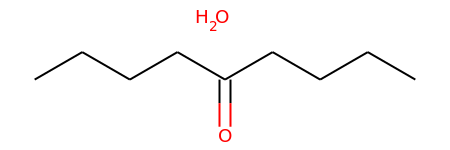

In [17]:
rdkit_dict["jobs/gens_1191_gen0.xyz.out"]

In [13]:
import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit import RDPaths
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolDraw2DSVG

from bokeh.plotting import ColumnDataSource, figure, output_file, show
from sklearn.decomposition import PCA
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [14]:

def mol2svg(mol):
    d2d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

def mol2fp(mol, radi=2, nBits=1024):
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radi, nBits=nBits)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


data = dict(
    x= processed_df["pca"],
    y= processed_df["freq"],
    ids = processed_df["filename"],
    img = processed_df["svg"],
    type_ = processed_df["type"],
    contacts =  processed_df["contacts"]
)



TOOLTIPS = """
<div> @ids <br>
@img{safe}
</div>
"""



KeyError: 'pca'

In [ ]:
from bokeh.models import ColorBar, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral6, Colorblind3
from bokeh.plotting import figure, output_file, show
from bokeh.transform import linear_cmap, factor_cmap

title = "PCA vs. Freq. (Test, Train, Generated)"
output_file("output/styling_linear_mappers.html", title="PCA vs. Freq. (Test, Train, Generated)")

#Use the field name of the column source
mapper = linear_cmap(field_name='contacts', palette=Spectral3, low=min(processed_df["contacts"]), high=max(processed_df["contacts"]))

# cat_mapper = CategoricalColorMapper(palette=Spectral6, factors=processed_df["type"])
cat_mapper = factor_cmap('type_', palette=Colorblind3, factors=sorted(processed_df.type.unique()), end=1)

source = ColumnDataSource(data)


p = figure(width=800, height=600, title=title, tooltips=TOOLTIPS)

p.circle(x='x', y='y', line_color=cat_mapper, color=cat_mapper, fill_alpha=1, size=10, source=source)

color_bar = ColorBar(color_mapper=cat_mapper['transform'], width=8)

p.add_layout(color_bar, 'right')

p.yaxis.axis_label = "Freq. [inv. cm]"
p.xaxis.axis_label = "PCA(Water Disp. Matrix)"
show(p)



In [18]:
processed_df

,filename,atomno,atomcoords,freq,disp,mol,svg,type,pca,contacts
0,jobs/gens_1191_gen17.xyz.out,"[8, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 8, 1, 1]","[[[2.254732, -1.111407, 0.139695], [1.076708, ...",3651.2351,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024eed850>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,jobs,0.677071,0.333333
1,jobs/gens_98-86_gen13.xyz.out,"[6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...","[[[-1.598772, 2.354839, 0.002411], [-1.726478,...",3606.1652,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8026f3bcb0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,jobs,1.011215,0.333333
2,jobs/gens_98-86_gen4.xyz.out,"[6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...","[[[1.500511, -1.865639, 0.014759], [0.956523, ...",3601.7481,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8026f3d3f0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,jobs,1.011898,0.333333
3,jobs/gens_62_gen1.xyz.out,"[7, 6, 6, 6, 6, 6, 6, 7, 6, 8, 1, 1, 1, 1, 1, ...","[[[-1.305979, -1.956823, -0.215492], [-0.17678...",3487.8021,"[[-0.05, 0.01, 0.0], [0.0, 0.0, 0.0], [0.0, 0....",<rdkit.Chem.rdchem.Mol object at 0x2b8026f39800>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,jobs,0.576967,4.000000
4,jobs/gens_62_gen1.xyz.out,"[7, 6, 6, 6, 6, 6, 6, 7, 6, 8, 1, 1, 1, 1, 1, ...","[[[-1.305979, -1.956823, -0.215492], [-0.17678...",3544.3211,"[[0.03, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",<rdkit.Chem.rdchem.Mol object at 0x2b8026f39800>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,jobs,0.745901,3.333333
...,...,...,...,...,...,...,...,...,...,...
244,test/502-49-8.out,"[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[-2.366504, -0.721183, -0.566332], [-2.35269...",3578.1188,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03710>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,test,-0.105465,0.000000
245,test/547-64-8.out,"[6, 6, 1, 6, 1, 1, 1, 6, 1, 1, 1, 8, 8, 8, 1, ...","[[[0.368967, 1.247959, 0.554036], [-0.590295, ...",3555.8714,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [-0.01, 0.0...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f038a0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,test,0.333016,3.000000
246,test/547-64-8.out,"[6, 6, 1, 6, 1, 1, 1, 6, 1, 1, 1, 8, 8, 8, 1, ...","[[[0.368967, 1.247959, 0.554036], [-0.590295, ...",3610.2268,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [-0.01, 0.0...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f038a0>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,test,-0.104781,3.000000
247,test/75-89-8.out,"[6, 6, 1, 1, 8, 1, 9, 9, 9, 8, 1, 1]","[[[-0.254547, 1.066764, -0.624224], [-0.861207...",3607.1661,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x2b8024f03670>,<?xml version='1.0' encoding='iso-8859-1'?>\n<...,test,0.151900,3.000000


In [59]:
Z_to_sym = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "", "", "", "", "", "", "", ""]
output_dir = "/scratch/boittier/hydra/"


for index, row in processed_df.iterrows():
#     print(row['atomcoords'], row['atomno'], row["freq"])
    filename = row["filename"].split("/")[-1] + ".xyz"
    atomic_sym = [Z_to_sym[x-1] for x in row['atomno']]
    atomic_coords = row['atomcoords']
    freq = row["freq"]
    print(atomic_coords.shape)
    with open(output_dir + filename, "w") as f:
        n_atoms = len(atomic_sym)
        f.write(f"{n_atoms}\n")
        f.write(f"{freq} \n")
        for sym, xyz in zip(atomic_sym, atomic_coords[-1]):
            s_out = f"{sym} {xyz[0]} {xyz[1]} {xyz[2]}\n"
            
            f.write(s_out)
        f.write("\n")
            

(47, 15, 3)
(33, 21, 3)
(22, 23, 3)
(44, 21, 3)
(44, 21, 3)
(44, 21, 3)
(42, 27, 3)
(20, 23, 3)
(42, 25, 3)
(42, 22, 3)
(42, 22, 3)
(42, 22, 3)
(43, 23, 3)
(69, 26, 3)
(86, 25, 3)
(37, 23, 3)
(53, 29, 3)
(30, 21, 3)
(65, 19, 3)
(51, 21, 3)
(51, 21, 3)
(30, 31, 3)
(34, 23, 3)
(87, 25, 3)
(14, 14, 3)
(20, 14, 3)
(29, 13, 3)
(29, 13, 3)
(21, 15, 3)
(27, 15, 3)
(28, 17, 3)
(39, 14, 3)
(39, 14, 3)
(22, 14, 3)
(38, 16, 3)
(15, 17, 3)
(47, 13, 3)
(47, 13, 3)
(47, 13, 3)
(47, 13, 3)
(26, 17, 3)
(26, 17, 3)
(24, 17, 3)
(24, 17, 3)
(24, 17, 3)
(53, 13, 3)
(53, 13, 3)
(53, 13, 3)
(53, 13, 3)
(28, 17, 3)
(28, 17, 3)
(21, 17, 3)
(53, 16, 3)
(23, 11, 3)
(22, 12, 3)
(39, 18, 3)
(30, 17, 3)
(19, 13, 3)
(20, 18, 3)
(29, 12, 3)
(23, 18, 3)
(23, 18, 3)
(23, 18, 3)
(21, 14, 3)
(19, 18, 3)
(63, 17, 3)
(63, 17, 3)
(25, 14, 3)
(32, 17, 3)
(27, 19, 3)
(27, 19, 3)
(27, 19, 3)
(21, 18, 3)
(24, 14, 3)
(31, 22, 3)
(22, 16, 3)
(33, 17, 3)
(23, 15, 3)
(28, 14, 3)
(49, 18, 3)
(32, 13, 3)
(41, 13, 3)
(26, 19, 3)
(26,

In [57]:
atomic_coords.shape

(47, 15, 3)